In [20]:
%load_ext autoreload
%autoreload 2

import torch
import copy

from text3d2video.rendering import render_depth_map
from text3d2video.utilities.video_util import pil_frames_to_clip
torch.set_grad_enabled(False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
from text3d2video.pipelines.generative_rendering_pipeline import (
    GenerativeRenderingPipeline
)
from text3d2video.pipelines.pipeline_utils import load_pipeline

device = torch.device("cuda")
dtype = torch.float16
sd_repo = "runwayml/stable-diffusion-v1-5"
controlnet_repo = "lllyasviel/control_v11f1p_sd15_depth"
pipe = load_pipeline(GenerativeRenderingPipeline, sd_repo, controlnet_repo)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [3]:
# MultiView
import numpy as np
import torch
from pytorch3d.io import load_obj, load_objs_as_meshes

from text3d2video.utilities.camera_placement import (
    cam_view_prompt,
    turntable_extrinsics,
)
from text3d2video.utilities.ipython_utils import display_ims
from text3d2video.utilities.mesh_processing import normalize_meshes
from pytorch3d.renderer import FoVPerspectiveCameras

mesh_path = "data/meshes/cat_statue.obj"
device = "cuda"

# read mesh
verts, faces, aux = load_obj(mesh_path)
verts_uvs = aux.verts_uvs.to(device)
faces_uvs = faces.textures_idx.to(device)

mesh = load_objs_as_meshes([mesh_path], device=device)
mesh = normalize_meshes(mesh)

dist = 6.5

# Small Rotation
# n_frames = 10
# center_angle = 0
# shift = 20
# angles = np.linspace(center_angle-shift, center_angle+shift, n_frames)

# Full Rotation
angles = np.linspace(0, 360, 10)

R, T = turntable_extrinsics(dists=dist, angles=angles)

frame_cams = FoVPerspectiveCameras(R=R, T=T, device="cuda", fov=10)
frame_meshes = mesh.extend(len(frame_cams))

prompt_suffixes = []
for angle in angles:
    view = cam_view_prompt(angle, 0)
    prompt_suffixes.append(f", {view} view")

In [22]:
# MultiView - 2D
from text3d2video.utilities.camera_placement import front_facing_extrinsics
from pytorch3d.renderer import FoVOrthographicCameras

mesh_path = "data/meshes/cat_statue.obj"
device = "cuda"

# read mesh
verts, faces, aux = load_obj(mesh_path)
verts_uvs = aux.verts_uvs.to(device)
faces_uvs = faces.textures_idx.to(device)

mesh = load_objs_as_meshes([mesh_path], device=device)
mesh = normalize_meshes(mesh)

n_frames = 10
dist = 6.5

# xs = torch.linspace(-0.3, 0.3, n_frames)
xs = [-0.3, 0.3]
R, T = front_facing_extrinsics(xs=xs, zs=1)

s = 1.5
frame_cams = FoVOrthographicCameras(R=R, T=T, device="cuda", scale_xyz=[(s, s, s)])
frame_meshes = mesh.extend(len(frame_cams))

prompt_suffixes = None

In [5]:
# Handstand
from text3d2video.artifacts.anim_artifact import AnimationArtifact

anim = AnimationArtifact.from_wandb_artifact_tag("handstand:latest")

# full
# frame_indices = anim.frame_indices(20)

# begining part
# up_to = 15
# frame_indices = torch.linspace(0, up_to, 7, dtype=torch.long)

# handstand
frame_indices = torch.linspace(30, 37, 7, dtype=torch.long)

frame_cams, frame_meshes = anim.load_frames(frame_indices)
verts_uvs, faces_uvs = anim.uv_data()

prompt_suffixes = None

In [6]:
# Rumba 
from text3d2video.artifacts.anim_artifact import AnimationArtifact

anim = AnimationArtifact.from_wandb_artifact_tag("ymca:latest")

# frame_indices = torch.linspace(30, 50, 7, dtype=torch.long)
frame_indices = anim.frame_indices(20)

frame_cams, frame_meshes = anim.load_frames(frame_indices)
verts_uvs, faces_uvs = anim.uv_data()
# prompt_suffixes = None

In [18]:
# MMA
from text3d2video.artifacts.anim_artifact import AnimationArtifact

anim = AnimationArtifact.from_wandb_artifact_tag("mma:latest")

# frame_indices = torch.linspace(0, 50, 30, dtype=torch.long)
frame_indices = torch.linspace(30, 35, 5, dtype=torch.long)

frame_cams, frame_meshes = anim.load_frames(frame_indices)
verts_uvs, faces_uvs = anim.uv_data()
# prompt_suffixes = None

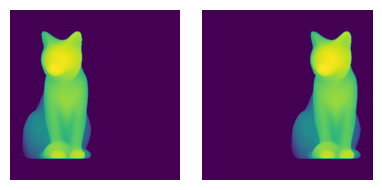

In [23]:
prompt = "Deadpool"
seed = 0
depths = render_depth_map(frame_meshes, frame_cams)
display_ims(depths, titles=prompt_suffixes)

In [24]:
from text3d2video.utilities.ipython_utils import display_vid


display_vid(pil_frames_to_clip(depths))

In [76]:
# Call GR
from pathlib import Path
from text3d2video.noise_initialization import (
    FixedNoiseInitializer,
    RandomNoiseInitializer,
    UVNoiseInitializer,
)
from text3d2video.pipelines.generative_rendering_pipeline import (
    GenerativeRenderingConfig,
)
from text3d2video.utilities.logging import GrLogger

module_paths = [
    # "down_blocks.0.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.0.attentions.1.transformer_blocks.0.attn1",
    # "down_blocks.1.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.1.attentions.1.transformer_blocks.0.attn1",
    # "down_blocks.2.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.2.attentions.1.transformer_blocks.0.attn1",
    "mid_block.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.2.transformer_blocks.0.attn1",
]

gr_config = GenerativeRenderingConfig(
    do_pre_attn_injection=True,
    do_post_attn_injection=True,
    feature_blend_alpha=1.0,
    attend_to_self_kv=False,
    mean_features_weight=0.0,
    chunk_size=5,
    num_keyframes=1,
    num_inference_steps=15,
    guidance_scale=15,
    controlnet_conditioning_scale=1.0,
    module_paths=module_paths,
)

generator = torch.Generator(device="cuda")
generator.manual_seed(seed)

kf_generator = torch.Generator(device="cuda")
kf_generator.manual_seed(0)

logger = GrLogger(Path("data.h5"), n_save_times=10, n_save_frames=10)
logger.delete_data()
logger.open_write()
logger.enabled = False


noise_initializer = FixedNoiseInitializer()
noise_initializer = RandomNoiseInitializer()
noise_initializer = UVNoiseInitializer(noise_texture_res=120)

video_frames = pipe(
    prompt,
    frame_meshes,
    frame_cams,
    verts_uvs,
    faces_uvs,
    generative_rendering_config=gr_config,
    noise_initializer=noise_initializer,
    generator=generator,
    kf_generator=kf_generator,
    logger=logger,
    prompt_suffixes=prompt_suffixes,
)

100%|██████████| 15/15 [00:09<00:00,  1.58it/s]


In [77]:
# Call ControlNet
controlnet_config = copy.deepcopy(gr_config)
controlnet_config.do_pre_attn_injection = False
controlnet_config.do_post_attn_injection = False

generator = torch.Generator(device="cuda")
generator.manual_seed(seed)

frames_controlnet = pipe(
    prompt,
    frame_meshes,
    frame_cams,
    verts_uvs,
    faces_uvs,
    generative_rendering_config=controlnet_config,
    noise_initializer=noise_initializer,
    generator=generator,
    kf_generator=kf_generator,
    logger=None,
    prompt_suffixes=prompt_suffixes,
)

100%|██████████| 15/15 [00:02<00:00,  5.58it/s]


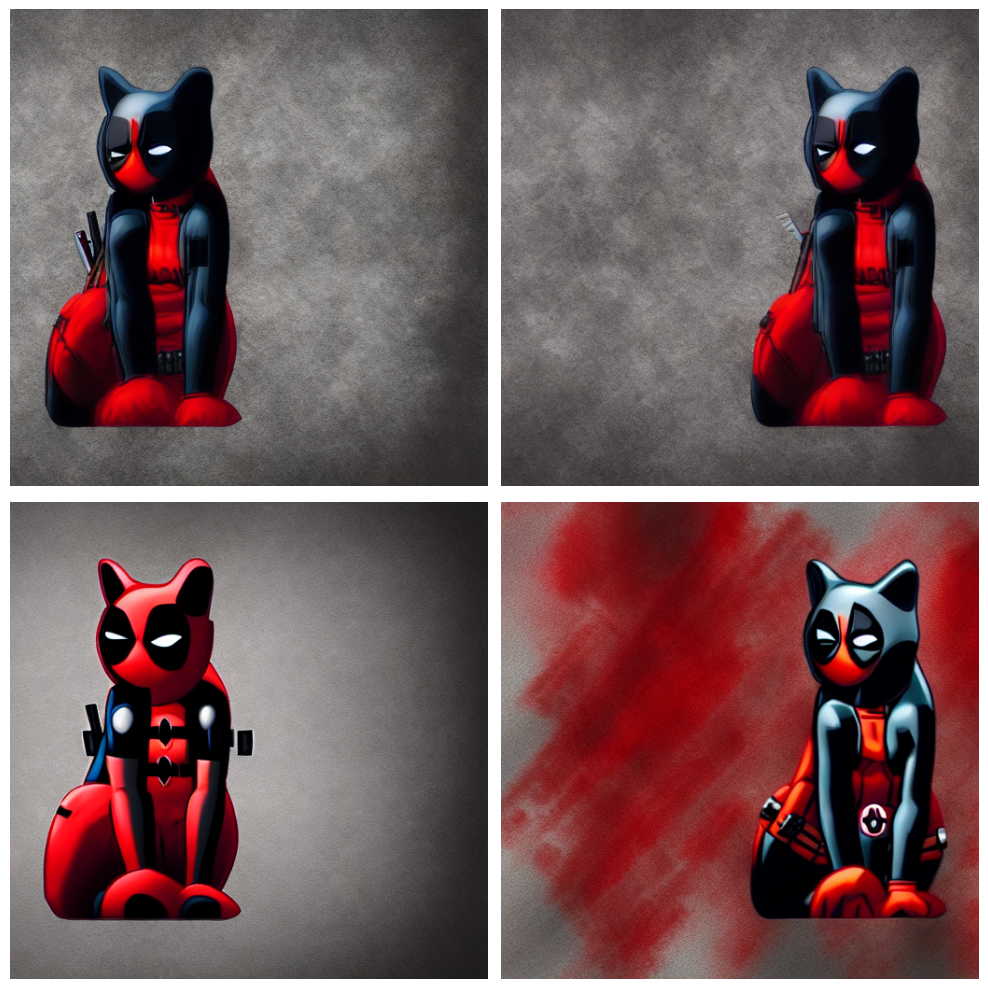

In [78]:
from text3d2video.utilities.ipython_utils import display_ims_grid


display_ims_grid([video_frames, frames_controlnet], scale=5)

In [19]:
from text3d2video.utilities.ipython_utils import display_vid
from text3d2video.utilities.video_comparison import video_grid

comparison_vids = [
    (pil_frames_to_clip(depths), "depth"),
    (pil_frames_to_clip(video_frames), "Generative Rendering"),
    (pil_frames_to_clip(frames_controlnet), "ControlNet"),
]

labels = [label for _, label in comparison_vids]
clips = [clip for clip, _ in comparison_vids]


comparison_vid = video_grid(
    [clips],
    x_labels=labels,
)
display_vid(comparison_vid, width=1000)